In [ ]:
import pandas as pd
from prophet import Prophet
import plotly.express as px

In [3]:
df_2024 = pd.read_csv("2024.csv")
df_2023 = pd.read_csv("2023.csv")

In [4]:
df = pd.concat([df_2023, df_2024])

In [5]:
df = df.rename(columns={"fecha": "ds", "tmed": "y"})

In [6]:
df["ds"] = pd.to_datetime(df["ds"])

In [7]:
regresores = ["prec", "tmin", "tmax", "hr_max", "hr_min", "hr_media", "dir", "velmedia", "racha"]

In [8]:
df = df.dropna(subset=["ds", "y"])
df = df.dropna(subset=regresores)

In [9]:
df_modelo = df[["ds", "y"] + regresores]

In [10]:
modelo = Prophet()

In [11]:
for reg in regresores:
    modelo.add_regressor(reg)

In [12]:
modelo.fit(df_modelo)

18:37:33 - cmdstanpy - INFO - Chain [1] start processing
18:47:13 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
predicciones = modelo.make_future_dataframe(periods=30)

for reg in regresores:
    predicciones[reg] = df[reg].mean()

forecast = modelo.predict(predicciones)

In [14]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
756,2025-01-26,16.314467,16.268430,16.363199
757,2025-01-27,16.317483,16.267450,16.366014
758,2025-01-28,16.320340,16.268856,16.366921
759,2025-01-29,16.323181,16.274115,16.372545
760,2025-01-30,16.325781,16.277804,16.370549


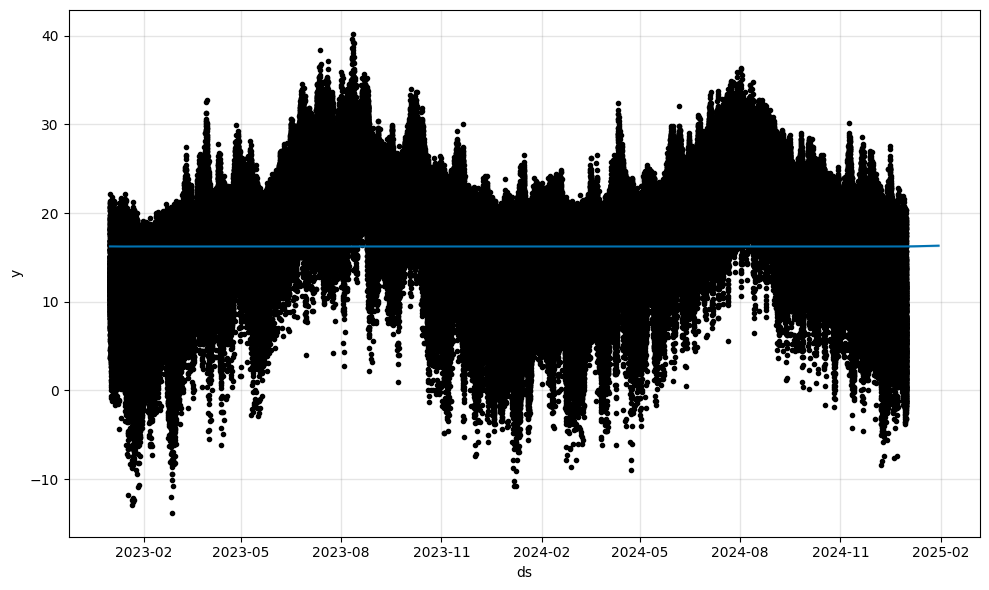

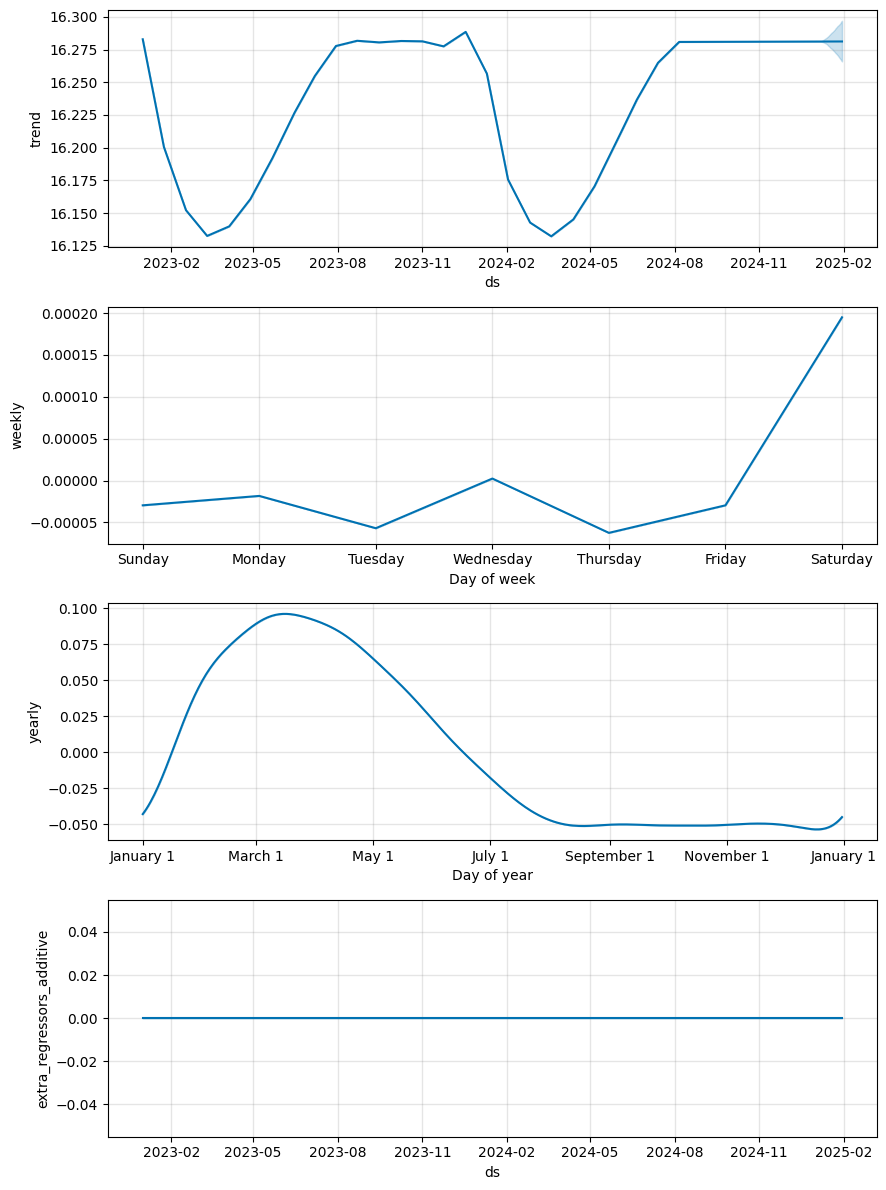

In [15]:
import matplotlib.pyplot as plt

modelo.plot(forecast)
plt.show()

modelo.plot_components(forecast)
plt.show()

In [56]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(modelo, initial='366 days', period='90 days', horizon='30 days')

df_p = performance_metrics(df_cv)

print(df_p.head())

  0%|          | 0/4 [00:00<?, ?it/s]

19:23:06 - cmdstanpy - INFO - Chain [1] start processing
19:24:01 - cmdstanpy - INFO - Chain [1] done processing
19:24:37 - cmdstanpy - INFO - Chain [1] start processing
19:28:14 - cmdstanpy - INFO - Chain [1] done processing
19:28:56 - cmdstanpy - INFO - Chain [1] start processing
19:35:13 - cmdstanpy - INFO - Chain [1] done processing
19:36:02 - cmdstanpy - INFO - Chain [1] start processing
19:39:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon       mse      rmse       mae     mdape     smape  coverage
0  4 days  0.001291  0.035926  0.027525  0.001526  0.002610  0.614801
1  5 days  0.001304  0.036118  0.027985  0.001542  0.002553  0.628717
2  6 days  0.001333  0.036504  0.028539  0.001567  0.002373  0.635588
3  7 days  0.001366  0.036955  0.029145  0.001695  0.002498  0.645006
4  8 days  0.001403  0.037460  0.029727  0.001835  0.003434  0.652568


In [50]:
def granularidad_prophet(df, freq, granularidad, periodo):

    df_resampled = df.resample(freq, on="ds").mean().reset_index()


    model = Prophet()
    model.fit(df_resampled)


    future = model.make_future_dataframe(periods=periodo, freq=freq)
    forecast = model.predict(future)

    fig = px.scatter(df_resampled, x="ds", y="y", 
                     title=f"Predicción con granularidad: {granularidad}", labels={"ds": "Fecha", "y": "Temperatura media"})
    fig.update_traces(mode = "lines+markers", name = "Datos reales")
    
    fig_pred = px.line(forecast, x="ds", y="yhat", labels={"ds": "Fecha", "yhat": "Predicción"})
    for trace in fig_pred.data:
        trace.line.dash = "dash"
        trace.name = "Predicción"
        fig.add_trace(trace)
    
    fig.add_scatter(
    x=forecast["ds"],
    y=forecast["yhat_lower"],
    mode="lines",
    line=dict(color="rgba(0,100,80,0.6)", width=1),
    hoverinfo="skip")

    fig.add_scatter(
        x=forecast["ds"],
        y=forecast["yhat_upper"],
        mode="lines",
        fill="tonexty",
        fillcolor="rgba(0,100,80,0.2)",
        line=dict(color="rgba(0,100,80,0.6)", width=1),
        hoverinfo="skip")
    
    fig.update_layout(showlegend=False)
    
    fig.show()

    ultima_fecha = df_resampled["ds"].max()

    prediccion_periodo = forecast[forecast["ds"] > ultima_fecha]

    prediccion_periodo = prediccion_periodo[["ds", "yhat", "yhat_lower", "yhat_upper"]]

    print(prediccion_periodo)


In [46]:
granularidades = {
    "Diario": "D",
    "Semanal": "W",
    "Mensual": "ME",
    "Trimestral": "QE",
    "Semestral": "2QE",
    "Anual": "YE"
}

In [51]:
for nombre, freq in granularidades.items():
    granularidad_prophet(df_modelo, freq, nombre, periodo=5)

19:17:19 - cmdstanpy - INFO - Chain [1] start processing
19:17:19 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
731 2025-01-01  9.404612    6.963831   11.978180
732 2025-01-02  9.441914    6.913718   12.254100
733 2025-01-03  9.248154    6.644891   11.683957
734 2025-01-04  9.164306    6.471172   11.538890
735 2025-01-05  9.232213    6.786327   11.644098


19:17:20 - cmdstanpy - INFO - Chain [1] start processing
19:17:20 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
106 2025-01-12  8.511104    6.667088   10.424466
107 2025-01-19  8.002669    6.053139   10.007593
108 2025-01-26  8.112944    6.050227   10.085142
109 2025-02-02  8.826260    6.955447   10.596964
110 2025-02-09  9.464261    7.445887   11.508840


19:17:20 - cmdstanpy - INFO - Chain [1] start processing
19:17:20 - cmdstanpy - INFO - Chain [1] done processing


           ds       yhat  yhat_lower  yhat_upper
24 2025-01-31  17.491373   10.725903   24.402749
25 2025-02-28  17.586308   10.469936   24.383831
26 2025-03-31  17.691415   10.833174   24.554928
27 2025-04-30  17.793131   11.232803   24.629760
28 2025-05-31  17.898238   11.166011   24.657016


19:17:21 - cmdstanpy - INFO - Chain [1] start processing
19:17:21 - cmdstanpy - INFO - Chain [1] done processing


19:17:21 - cmdstanpy - INFO - Chain [1] start processing


           ds       yhat  yhat_lower  yhat_upper
8  2025-03-31  17.628588   11.521813   23.704084
9  2025-06-30  17.950445   11.410926   23.257269
10 2025-09-30  18.275839   12.476575   24.473077
11 2025-12-31  18.601233   12.416037   24.511251
12 2026-03-31  18.919554   13.476607   25.171473


19:17:23 - cmdstanpy - INFO - Chain [1] done processing


19:17:23 - cmdstanpy - INFO - Chain [1] start processing


          ds       yhat  yhat_lower  yhat_upper
5 2025-09-30  23.545290   22.598326   24.522057
6 2026-03-31  14.316439   11.120423   17.713814
7 2026-09-30  27.192825   20.981208   33.791541
8 2027-03-31  15.172708    4.570144   25.310200
9 2027-09-30  30.883496   15.962617   45.228936


19:17:26 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat  yhat_lower  yhat_upper
2 2025-12-31  15.889500   15.889500   15.889500
3 2026-12-31  15.662482   15.662482   15.662482
4 2027-12-31  15.435464   15.435463   15.435465
5 2028-12-31  15.207824   15.207823   15.207826
6 2029-12-31  14.980807   14.980805   14.980808
